In [4]:
import tensorflow as tf
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

train_dir = '../../dataset/images/train'
validation_dir = '../../dataset/images/validation'
test_dir = '../../dataset/images/test'

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 14228 files belonging to 2 classes.
Found 4086 files belonging to 2 classes.
Found 2013 files belonging to 2 classes.


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


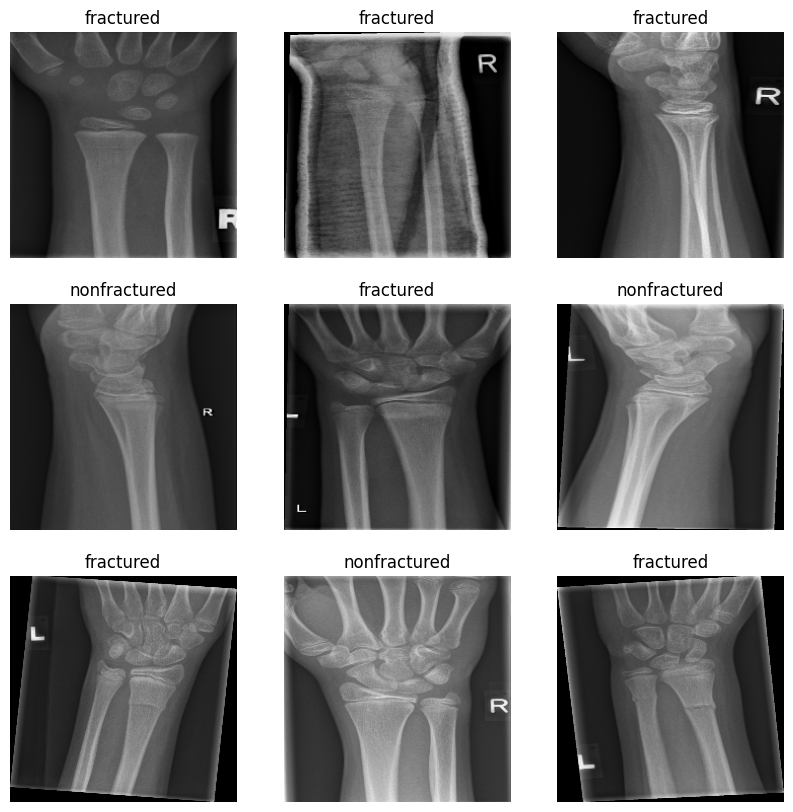

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# class Xception():
#     pass

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

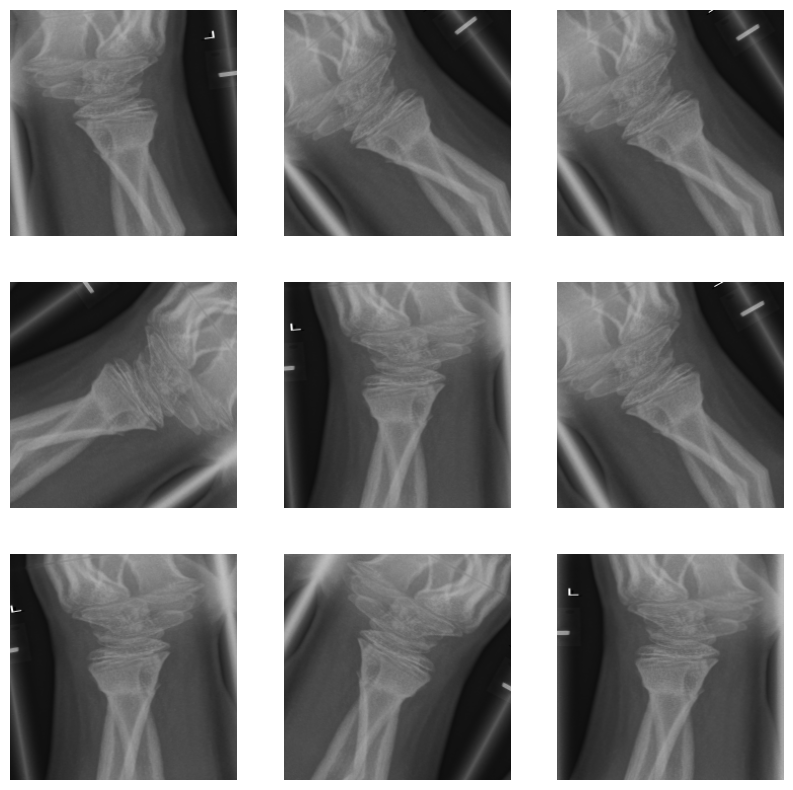

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-12-04 00:21:25.947281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-04 00:21:26.955993: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-04 00:21:27.349933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(32, 7, 7, 2048)


In [11]:
base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [13]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

128/128 [==============================] - 15s 111ms/step - loss: 0.6207 - accuracy: 0.6760


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


445/445 [==============================] - 70s 150ms/step - loss: 0.4994 - accuracy: 0.7435 - val_loss: 0.4975 - val_accuracy: 0.7293
Epoch 2/10
445/445 [==============================] - 67s 149ms/step - loss: 0.4706 - accuracy: 0.7633 - val_loss: 0.4710 - val_accuracy: 0.7660
Epoch 3/10
445/445 [==============================] - 67s 149ms/step - loss: 0.4538 - accuracy: 0.7735 - val_loss: 0.5836 - val_accuracy: 0.6933
Epoch 4/10
445/445 [==============================] - 67s 149ms/step - loss: 0.4481 - accuracy: 0.7799 - val_loss: 0.4490 - val_accuracy: 0.7812
Epoch 5/10
445/445 [==============================] - 67s 149ms/step - loss: 0.4486 - accuracy: 0.7796 - val_loss: 0.4460 - val_accuracy: 0.7817
Epoch 6/10
445/445 [==============================] - 67s 149ms/step - loss: 0.4421 - accuracy: 0.7842 - val_loss: 0.4464 - val_accuracy: 0.7905
Epoch 7/10
445/445 [==============================] - 67s 150ms/step - loss: 0.4376 - accuracy: 0.7885 - val_loss: 0.4447 - val_accuracy: 0.7